# Solving 2-dimensional shallow water equation

## Mathematical problem statement

\begin{align}
\begin{pmatrix}
	h \\ hu \\ hv
\end{pmatrix}_t +
\begin{pmatrix}
	hu \\ hu^2+\frac{1}{2}gh^2 \\ huv
\end{pmatrix}_x + 
\begin{pmatrix}
	hv \\ huv \\ hv^2+\frac{1}{2}gh^2 
\end{pmatrix}_y = 0
\end{align}

$h$ represents the water height, $u$ the velocity in $x$- and $v$ the velocity in $y$-direction. Therefore $hu$ and $hv$ describe the momenta in the corresponding direction. It is noted that with the described hyperbolic model as in eq. (1) fluid viscosity is ignored. $g>0$ denotes the constant gravity acceleration and is chosen to be $g=1.0$. In order to numerically solve this system of equations the eigenvalues of the flux Jacobian matrices, represented by $D_f$ and $D_g$, are needed for the evaluation of the local Lax-Friedrichs flux. Those are
\begin{equation*}
	\lambda(D_f)=\begin{pmatrix}
		u-c \\ u \\ u+c
	\end{pmatrix}
	\ \textrm{and }
	\lambda(D_g)=\begin{pmatrix}
		v-c \\ v \\ v+c
	\end{pmatrix},
\end{equation*} 
where $c=\sqrt{gh}$ describes the speed of gravity waves. Roughly speaking, the dimension-less $Froude$ number measures disturbance in the flow. In the one-dimensional case it is computed as $Fr=\frac{|u|}{c}$. $Fr<1$ indicates subcritical flow and $Fr>1$ supercritical flow.

We solve over the computational domain $\Omega$ and up to the final time horizon $T$ as given below. 
\begin{align*}
	\Omega &= [0,1] \times [0,1], \\
	T &= 0.6.
\end{align*}
At the boundary of our computational domain we assume solid walls.

With $U:=[h,hu,hv]^T$, the following IVP is considered in order to test the resolution properties of the dimension-by-dimension CWENO approach.

\begin{align*}
	U_0(x,y) &= 
	\begin{cases}
		[1,0,0]^T,\ \textrm{if } \sqrt{(x-0.5)^2+(y-0.5)^2} \leq 0.25 \\
		[0.5,0,0]^T,\ \textrm{else}
	\end{cases}.
\end{align*}

## Numerical solution

In [2]:
import numpy as np
from higher_order_CWENO_boundary_treatment.uniform_CWENO_2D import CWENO3_2D, CWENO5_2D, CWENO7_2D

### Time integrator method

Here, we use a dedicated time integrator method adapted for the shallow water equations problem statement. This repository however ships with some standard Runge-Kutta solvers in its utils as well.

In [3]:
class Explicit_RK3_2D_SWE:
    """ Base class for one step SSP Runge Kutta time integrator method of
    order 3 for systems. The class is modified in order to integrate the 
    SWE with adaptive time step size. """
    
    A = np.array([[0,0,0], [1,0,0], [1/4,1/4,0]])
    b = np.array([1/6, 1/6, 2/3])
    
    def __init__(self, u0, T, h, c_safety, function):
        """ The constructor. """
        self.u0 = u0
        self.T = T
        self.t = 0
        self.h = h
        self.c_safety = c_safety
        self.f = function
        self.d = u0.shape[0]
        self.Nx = u0.shape[1]
        self.Ny = u0.shape[2]
        self.s = int(0 if self.b is None else len(self.b))
        
    def solve(self):
        """ Method solving problem up to desired time horizon. """
        solution = []
        times = []
        solution.append(self.u0)
        times.append(self.t)
        i = 1
        while self.t < self.T:
            lam_x = np.amax(np.abs(solution[i-1][1,:,:]/solution[i-1][0,:,:]) 
                            + np.sqrt(solution[i-1][0,:,:]))
            lam_y = np.amax(np.abs(solution[i-1][2,:,:]/solution[i-1][0,:,:]) 
                            + np.sqrt(solution[i-1][0,:,:]))
            tau = self.c_safety*self.h/max(lam_x,lam_y)
            tau = min(tau,self.T-self.t)
            k = np.zeros([self.d,self.Nx,self.Ny,len(self.b)])
            for j in range(len(self.b)):
                k[:,:,:,j] = self.f(solution[i-1] + tau*np.dot(k,self.A[j,:]))
                
            solution.append(solution[i-1]+tau*np.dot(k,self.b))
            self.t+=tau
            times.append(self.t)
            i+=1
        
        return solution, times

### Setup of initial conditions and numerical grid

In [4]:
g = 1.0                     # gravitational constant
c_safety = 0.45             # safety constant for time step size
height_bottom = 0.05        # height of bottom water
height_top = 1              # height of top water 'behind' dam

domain=[0,1]                # computational domain [0,1]^2
T = 0.6                     # time horizon
n = 160                     # no. of cells used in each dimension
h = (domain[1]-domain[0])/n # cell size

gridx, gridy = np.meshgrid(np.linspace(domain[0]+h/2, domain[1]-h/2, n),
                           np.linspace(domain[0]+h/2, domain[1]-h/2, n))

# set radial initial water height in each cell
height = height_bottom*np.ones((n,n))
height[np.where(np.sqrt(np.power(gridx-0.5,2)+np.power(gridy-0.5,2))<=0.25)] = height_top     
U = np.zeros((3,n,n))
U[0,:,:] = height

### flux functions and eigenvalues

Here we define the flux functions as well as the eigenvalues of the Jacobian matrices as needed.

In [5]:
def flux_f(u):
    # flux f(u)
    res = np.zeros(u.shape)
    res[0,:,:] = u[1,:,:]
    res[1,:,:] = np.divide(np.power(u[1,:,:],2),u[0,:,:]) + 0.5*g*np.power(np.maximum(u[0,:,:],0),2)
    res[2,:,:] = np.divide(np.multiply(u[1,:,:],u[2,:,:]),u[0,:,:])

    return res
    
def eig_Df(u):
    c = np.sqrt(g*np.maximum(u[0,:,:],0))
    return np.array([np.divide(u[1,:,:],u[0,:,:])-c,np.divide(u[1,:,:],u[0,:,:]),
                     np.divide(u[1,:,:],u[0,:,:])+c])
    
def flux_g(u):
    # flux g(u)
    res = np.zeros(u.shape)
    res[0,:,:] = u[2,:,:]
    res[1,:,:] = np.divide(np.multiply(u[1,:,:],u[2,:,:]),u[0,:,:])
    res[2,:,:] = np.divide(np.power(u[2,:,:],2),u[0,:,:]) + 0.5*g*np.power(np.maximum(u[0,:,:],0),2)

    return res
    
def eig_Dg(u):
    c = np.sqrt(g*np.maximum(u[0,:,:],0))
    return np.array([np.divide(u[2,:,:],u[0,:,:])-c,np.divide(u[2,:,:],u[0,:,:]),
                     np.divide(u[2,:,:],u[0,:,:])+c])

In [6]:
def local_lax_friedrichs_flux_SWE_2D(u,v,func,spec):
    """ Method implementing the local Lax Friedrichs numerical flux function adapted for SWEs 
    in order to avoid negative water heights. """
    
    h_min = 1e-08
    zero_height = np.where(u[0,:,:] < h_min)
    u[1,:,:][zero_height], u[2,:,:][zero_height] = 0, 0
    zero_height = np.where(v[0,:,:] < h_min)
    v[1,:,:][zero_height], v[2,:,:][zero_height] = 0, 0
    
    sigma = np.maximum(np.abs(spec(u)),np.abs(spec(v)))
    
    return 1/2*(func(u)+func(v)-sigma*(u-v))

In [7]:
def reconstructed_interfaces_2D(data, hx, hy, params, order):
    """ Helper function calling the CWENO operators of corresponding order for 
    reconstruction of cell interfaces in two space dimensions. 
    The feasible orders are 3, 5 or 7. """
    
    if order == 3:
        CWENO_2D = CWENO3_2D(data,hx,hy,params[0],params[1],params[2],params[-1])
    elif order == 5:
        CWENO_2D = CWENO5_2D(data,hx,hy,params[0],params[1],params[2],params[-1])
    elif order == 7:
        CWENO_2D = CWENO7_2D(data,hx,hy,params[0],params[1],params[2],params[-1])
        
    left, right, down, up = CWENO_2D.reconstruct_cell_interfaces()
    
    return left, right, down, up

Defining the right-hand-side of our system of equations assuming solid reflecting walls at the boundary of our computational domain $\Omega$

In [8]:
def RHS_SWE_2D_solid_walls(U, h, flux_f, dflux_f, flux_g, dflux_g, params, order):
    """ Method implementing the RHS (right hand side) of the SWE simulation with solid wall 
    boundary conditions with desired order. """
    
    d = U.shape[0]
    left, right, down, up = np.zeros(U.shape), np.zeros(U.shape), np.zeros(U.shape), np.zeros(U.shape)
    # CWENO reconstruction componentwise
    for i in range(d):
        left[i,:,:], right[i,:,:], down[i,:,:], up[i,:,:] = reconstructed_interfaces_2D(U[i,:,:],h,h,params,order)        

    # copy the reconstructed interfaces to the corresponding position
    left = np.asarray([np.c_[left[i,:,:],right[i,:,-1]] for i in range(left.shape[0])])
    right = np.asarray([np.c_[left[i,:,0],right[i,:,:]] for i in range(right.shape[0])])
    down = np.asarray([np.r_['0,2',down[i,:,:],up[i,-1,:]] for i in range(down.shape[0])])
    up = np.asarray([np.r_['0,2',down[i,0,:],up[i,:,:]] for i in range(up.shape[0])])    
    # negate x-velocity components at left and right boundaries
    left[1,:,-1], right[1,:,0] = -left[1,:,-1], -right[1,:,0]    
    # negate y-velocity components at upper and lower boundaries
    down[2,-1,:], up[2,0,:] = -down[2,-1,:], -up[2,0,:]
        
    # right border numerical fluxes:
    H_right = local_lax_friedrichs_flux_SWE_2D(left[:,:,1:],right[:,:,1:],flux_f,dflux_f)
    # left border numerical fluxes:
    H_left = local_lax_friedrichs_flux_SWE_2D(left[:,:,:-1],right[:,:,:-1],flux_f,dflux_f)
    # right border numerical fluxes:
    H_up = local_lax_friedrichs_flux_SWE_2D(down[:,1:,:],up[:,1:,:],flux_g,dflux_g)
    # left border numerical fluxes:
    H_down = local_lax_friedrichs_flux_SWE_2D(down[:,:-1,:],up[:,:-1,:],flux_g,dflux_g)

    return -(H_right-H_left+H_up-H_down)/h

### CWENO parameters

In [9]:
order = 3
cweno_params = (
    h**2,                       # grid-dependent epsilon (critical for stability, originally introduced to avoid division by 0)
    2,                          # power parameter >=2
    0.5,                        # initial weight of P0 polynomial, weights of remaining polynomials are derived from this
    (0.75-h**2, h**2, 0.25)     # CWENO weights used for reconstructions in boundary cells
)
num_flux = lambda x: RHS_SWE_2D_solid_walls(x, h, flux_f, eig_Df, flux_g, eig_Dg, cweno_params, order)
CWENO_based_solver = Explicit_RK3_2D_SWE(U, T, h, c_safety, num_flux)

### Solve

Finally, we get to numerically solve our differential equations.

In [10]:
sol, times = CWENO_based_solver.solve()

## Plot results

In [11]:
import matplotlib.pyplot as plt

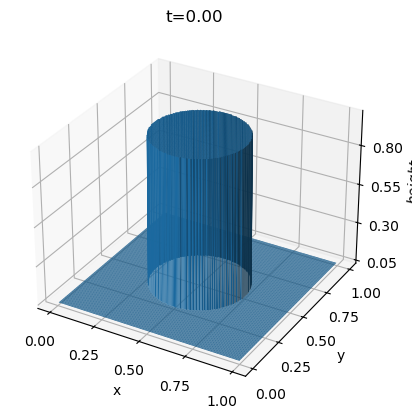

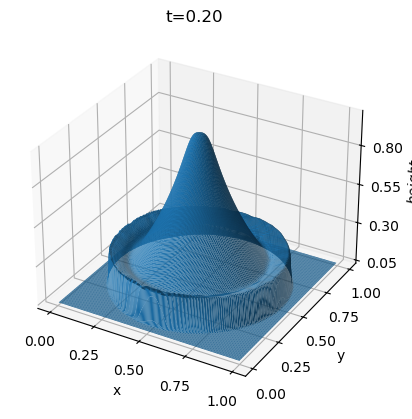

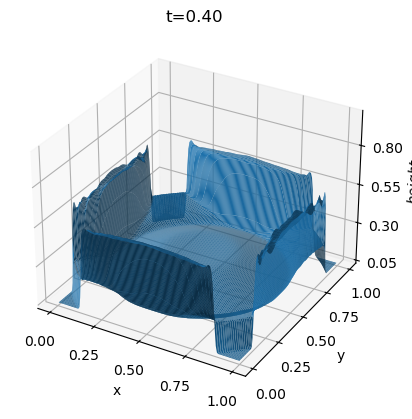

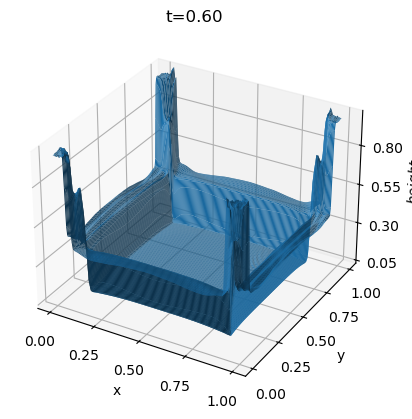

In [15]:
tt = np.arange(0,T+0.01,0.2)
frames = []
for t in tt:
    frames.append((np.abs(times - t)).argmin())
min_height = np.amin([sol[frame][0,:,:] for frame in frames])
for idx, frame in enumerate(frames):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.xaxis.set_ticks(np.arange(0,1.1,0.25))
    ax.yaxis.set_ticks(np.arange(0,1.1,0.25))
    ax.zaxis.set_ticks(np.arange(height_bottom,height_top+0.1,0.25))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'$height$')
    ax.set_zlim(min_height,height_top)
    ax.set_title(f't={tt[idx]:.2f}')
    ax.plot_surface(X=gridx,Y=gridy,Z=sol[frame][0,:,:],rstride=1,cstride=1, antialiased=True)
